a# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

# from utils.utils import generate_synthetic_data, generate_final_features, split_dataset
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

In [ ]:
!pip install pendulum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
from pendulum import DateTime
from pendulum import duration
import pandas as pd
import numpy as np
from random import randint
from sklearn.model_selection import train_test_split

def generate_synthetic_data(duration_cycle, start_day, year, start_month_index=1, number_of_cycle=5, period_duration=30, cycle_interval=[5, 6], period_interval=[26, 30]):
    """
    function that generate the synthetic data

        Args:
            duration_cycle (int): duration of the cycle in days
            start_day (int): day of the first cycle
            year (int): year of the first cycle
            start_month_index (int): month of the first cycle
            number_of_cycle (int): number of cycles
            period_duration (int): duration of the period between cycles in days
            cycle_interval (list): interval of the duration of the cycle in days
            period_interval (list): interval of the duration of the period between cycles in days

        Return:
            df (pd.DataFrame): dataframe with the synthetic data
        """
    data_frame = pd.DataFrame(columns=['M', 'Day', 'Year', 'Duration'])

    start_time = DateTime(year, start_month_index, start_day, 1, 0, 0)
    end_time = start_time+duration(days=duration_cycle)

    for _ in range(0, number_of_cycle+1):

            data_frame = pd.concat([data_frame, pd.DataFrame(np.array([[start_time.month, start_time.day, start_time.year, 'Starts']]),
                                                             columns=['M', 'Day', 'Year', 'Duration'])],  ignore_index=True, axis=0)

            data_frame = pd.concat([data_frame, pd.DataFrame(np.array([[end_time.month, end_time.day, end_time.year, 'Ends']]),
                                                             columns=['M', 'Day', 'Year', 'Duration'])],  ignore_index=True, axis=0)

            #TODO(Cibely): Make the durantion_cycle and period_duration be random values
            duration_cycle = randint(cycle_interval[0], cycle_interval[1])
            period_duration = randint(period_interval[0], period_interval[1])

            start_time = start_time+duration(days=period_duration)
            end_time = start_time+duration(days=duration_cycle)

    return data_frame


def calculate_period_length(dates, dates_numbers):
    """
    function that calculate the length of the period

    Args:
        dates (list): list of dates
        dates_numbers (int): number of dates

    Returns:
        period_length (list): list of length of the period in days
    """
    period_length = []
    for index in range(0,dates_numbers,2):
        period_length.append((dates[index+1] - dates[index]).days)

    return period_length


def calculate_cycle_length(dates, dates_numbers):
    """
    function that calculate the length of the cycle

    Args:
        dates (list): list of dates
        dates_numbers (int): number of dates

    Returns:
        cycle_length (list): list of length of the cycle in days
    """
    cycle_length = []
    for index in range(0,dates_numbers-2,2):
        cycle_length.append((dates[index+2] - dates[index]).days)

    return cycle_length


def calculate_datatime(dataset):
    """
    function that calculate the datetime of the dates

    Args:
        dataset (pd.DataFrame): dataframe with the data

    Returns:
        formatted_dataset (list): list with the features
    """

    dates_format=pd.to_datetime(dict(year=dataset.Year, month=dataset.M, day=dataset.Day))
    period_length=calculate_period_length(dates_format, len(dataset))
    cycle=calculate_cycle_length(dates_format, len(dataset))

    formatted_dataset=[]
    index=0
    for date_index in range(0,len(dates_format)-2,2):
        formatted_dataset.append([dates_format[date_index].date(), cycle[index], period_length[index]])
        index+=1

    return formatted_dataset


def prepared_the_features(periods):
    """
    function that prepare the features for the prediction


    Args:
        periods (list): list of the periods

    Returns:
        features (np.array): array with the features
        labels (np.array): array with the labels
    """

    features = []
    labels = []
    for period in periods[:-3]:
        p_index = periods.index(period)
        features.append([])
        features[-1].append([period[-2], period[-1]])
        features[-1].append([periods[p_index + 1][-2], periods[p_index + 1][-1]])
        features[-1].append([periods[p_index + 2][-2], periods[p_index + 2][-1]])
        labels.append([periods[p_index + 3][-2], periods[p_index + 3][-1]])
    #TODO(Cibely): verify that len(features) == len(labels) must be true

    return features, labels


def generate_final_features(dataset):
    """
    function that generate the final dataset

    Args:
        dataset (pd.DataFrame): dataframe with the data

    Returns:
        final_dataset (list): list with the final dataset
    """

    dataset_with_datatime = calculate_datatime(dataset)

    return prepared_the_features(dataset_with_datatime)

def split_dataset(features, labels, test_size=0.2, random_state=0, reshape=True):
    """
    function that split the dataset

    Args:
        features (np.array): array with the features
        labels (np.array): array with the labels
        test_size (float): percentage of the test size
        random_state (int): random state

    Returns:
        train_features (np.array): array with the train features
        test_features (np.array): array with the test features
        train_labels (np.array): array with the train labels
        test_labels (np.array): array with the test labels
    """


    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    train_features = np.array(train_features)
    test_features = np.array(test_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    if reshape:
        train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2])
        test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2])
        train_labels = train_labels.reshape(train_labels.shape[0], train_labels.shape[1]*1)
        test_labels = test_labels.reshape(test_labels.shape[0], test_labels.shape[1]*1)

    return train_features, test_features, train_labels, test_labels

def create_dataset(dataset, look_back=1):
    """
        This function is used to create dataset for LSTM model
        Args:
            dataset: The dataset
            look_back: The number of previous time steps to use as input variables to predict the next time period
        Returns:
            dataX: The input data
            dataY: The output data
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def convet2dataframe(data, columns):
    """
    function that convert the data to dataframe

    Args:
        data (np.array): array with the data
        columns (list): list with the columns

    Returns:

    """
    data = data.reshape(1,-1,2)
    data_frame = pd.DataFrame(data[0], columns=columns)
    data_frame['time'] = data_frame.index
    return data_frame

# Load Data

In [ ]:
total_regular_cycle_data = pd.read_csv("https://raw.githubusercontent.com/DodyNaufal/Bike_Sharing_Dataset/main/total_regular_cycle_data.csv")

In [ ]:
total_regular_cycle_data.head()

,M,Day,Year,Duration
0,1,25,2021,Starts
1,1,30,2021,Ends
2,2,24,2021,Starts
3,3,1,2021,Ends
4,3,26,2021,Starts


In [ ]:
# generate the final features
features_total_regular_cycle_data, labels_total_regular_cycle_data = generate_final_features(total_regular_cycle_data)

In [ ]:
# slice the data with split_dataset function
input_train_total_regular_cycle, input_test_total_regular_cycle, output_train_total_regular_cycle, output_test_total_regular_cycle = split_dataset(features_total_regular_cycle_data, labels_total_regular_cycle_data, reshape=False)

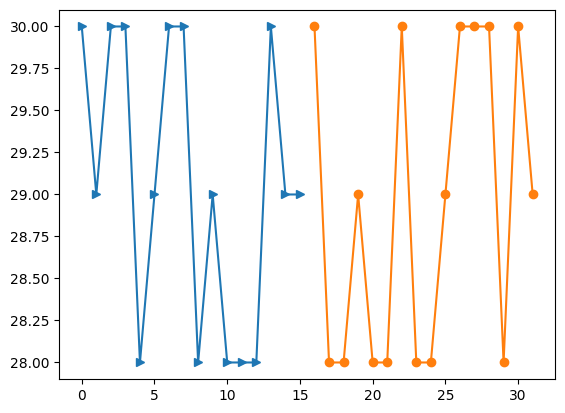

In [ ]:
plt.plot(np.arange(16),input_train_total_regular_cycle[:,0,0], '->')
plt.plot(np.arange(16, 2*16),output_train_total_regular_cycle[:,0], '-o')

#Create Model

In [ ]:
# create and fit the LSTM network
n_features = input_train_total_regular_cycle.shape[2]
model = Sequential()
model.add(LSTM(64, input_shape=(3, n_features),  activation='tanh'))
model.add(Dropout(0.05))
model.add(Dense(n_features, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 17282 (67.51 KB)
Trainable params: 17282 (67.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, run_eagerly=True)
# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(input_train_total_regular_cycle, output_train_total_regular_cycle, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 0s 401ms/step - loss: 0.7213 - val_loss: 0.3580
Epoch 2/100
1/1 [==============================] - 0s 95ms/step - loss: 1.4511 - val_loss: 0.3644
Epoch 3/100
1/1 [==============================] - 0s 125ms/step - loss: 0.9603 - val_loss: 0.3728
Epoch 4/100
1/1 [==============================] - 0s 122ms/step - loss: 0.7314 - val_loss: 0.3836
Epoch 5/100
1/1 [==============================] - 0s 113ms/step - loss: 1.3042 - val_loss: 0.3954
Epoch 6/100
1/1 [==============================] - 0s 81ms/step - loss: 0.7434 - val_loss: 0.4093


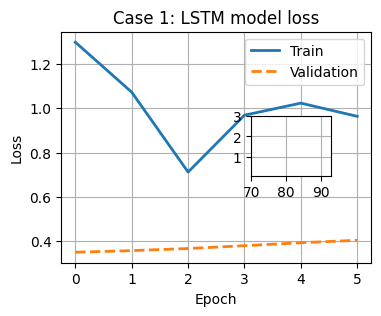

In [ ]:
# plot the loss and val loss
plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '--', linewidth=2)
plt.grid(True)
plt.legend(['Train', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Case 1: LSTM model loss')
ax = plt.axes([0.6, 0.4, .20, .20])
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '--', linewidth=2)
plt.grid(True)
ax.set_ylim(0.1, 3)
ax.set_xlim(70, 93)
# save history
history_df = pd.DataFrame(history.history)
history_df.to_csv('case1_history_lstm.csv', index=False)


In [ ]:
# make predictions
trainPredict = model.predict(input_train_total_regular_cycle)
testPredict = model.predict(input_test_total_regular_cycle)
testPredict = np.round(testPredict)

1/1 [==============================] - 0s 54ms/step


In [ ]:
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(output_test_total_regular_cycle, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# calculate mean absolute error
testScore = mean_absolute_error(output_test_total_regular_cycle, testPredict)
print('Test Score: %.2f MAE' % (testScore))

# calculate r2 score
testScore = r2_score(output_test_total_regular_cycle, testPredict)
print('Test Score: %.2f R2' % (testScore))




Test Score: 20.65 RMSE
Test Score: 14.60 MAE
Test Score: -760.79 R2


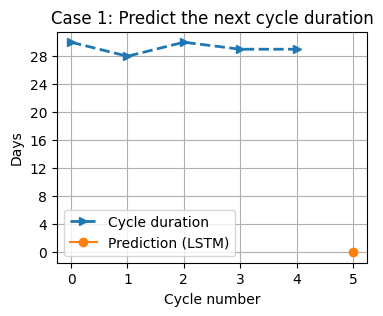

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(4, 3))
plt.plot(np.arange(5),output_test_total_regular_cycle[:,0], '-->', linewidth=2.0)
plt.plot(np.arange(5, 6),testPredict[0,0], '-o')
# round the number in axis
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylabel('Days')
plt.xlabel('Cycle number')
plt.legend(['Cycle duration', 'Prediction (LSTM)'])
plt.title('Case 1: Predict the next cycle duration')
plt.grid(True)
plt.show()

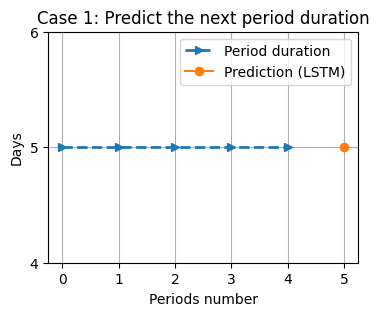

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(np.arange(5),output_test_total_regular_cycle[:,1], '-->', linewidth=2.0)
plt.plot(np.arange(5, 6),testPredict[0,1], '-o')
# round the number in axis
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
#set the y axis range
plt.ylim(4, 6)
plt.ylabel('Days')
plt.xlabel('Periods number')
plt.legend(['Period duration', 'Prediction (LSTM)'])
plt.title('Case 1: Predict the next period duration')
plt.grid(True)
plt.show()

In [ ]:
# Fungsi untuk prediksi ovulasi
def prediksi_ovulasi_lstm(model):
    tanggal_mulai = input("Masukkan tanggal mulai siklus menstruasi (format YYYY-MM-DD): ")
    panjang_siklus = int(input("Masukkan panjang siklus menstruasi (dalam hari): "))

    # Mengonversi input tanggal menjadi objek datetime
    tanggal_mulai_dt = datetime.strptime(tanggal_mulai, '%Y-%m-%d')

    # Buat fitur yang diperlukan untuk prediksi menggunakan model LSTM
    features = []
    for i in range(3):
        features.append([panjang_siklus - (i * 2), panjang_siklus - (i * 2)])

    features = np.array(features).reshape(1, 3, 2)

    # Prediksi panjang siklus dan periode berikutnya menggunakan model LSTM
    prediksi = model.predict(features)
    prediksi_siklus_berikutnya = int(prediksi[0, 0])
    prediksi_periode_berikutnya = int(prediksi[0, 1])

    # Menghitung hari ovulasi
    hari_ovulasi = prediksi_siklus_berikutnya

    # Menghitung tanggal ovulasi untuk bulan depan
    tanggal_mulai_bulan_depan = tanggal_mulai_dt.replace(day=28) + timedelta(days=4)  # untuk menghindari bulan yang lebih pendek
    tanggal_mulai_bulan_depan = tanggal_mulai_bulan_depan - timedelta(days=tanggal_mulai_bulan_depan.day) + timedelta(days=tanggal_mulai_dt.day)
    tanggal_ovulasi_bulan_depan = tanggal_mulai_bulan_depan + timedelta(days=hari_ovulasi)

    print(f"Tanggal ovulasi Anda diperkirakan jatuh pada {tanggal_ovulasi_bulan_depan.date()}.")

# Contoh pelatihan model LSTM dan menyimpan model
def train_and_save_model():
    # Contoh data latihan
    input_train_total_regular_cycle = np.random.rand(100, 3, 2)
    output_train_total_regular_cycle = np.random.rand(100, 2)

    n_features = input_train_total_regular_cycle.shape[2]
    model = Sequential()
    model.add(LSTM(64, input_shape=(3, n_features), activation='tanh'))
    model.add(Dropout(0.05))
    model.add(Dense(n_features, activation='relu'))
    model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)

    # Pelatihan model
    model.fit(input_train_total_regular_cycle, output_train_total_regular_cycle, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Menyimpan model
    model.save('lstm_model.h5')

# Pelatihan dan penyimpanan model (hanya perlu dijalankan sekali)
train_and_save_model()

# Muat model yang telah disimpan
model = load_model('lstm_model.h5')

# Contoh penggunaan fungsi prediksi ovulasi
prediksi_ovulasi_lstm(model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17152     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17282 (67.51 KB)
Trainable params: 17282 (67.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 8s 1s/step - loss: 0.2521 - val_loss: 0.2388
Epoch 2/10
3/3 [==============================] - 0s 92ms/step - loss: 0.2022 - val_loss: 0.2372
Epoch 3/10
3/3 [==============================] - 0s 81ms/step - loss: 0.1973 - val_loss: 